# Convex Hull

## Point representation

The first geometric entity to consider is a point. Here we will consider planar problems, so a point can be represented by its $(x,y)$ coordinates, as two `Float64` numbers in Julia. Here we will simply use a vector with 2 elements.

To store a *collection of points*, we could store the $(x,y)$ coordinates as the columns or the rows of a 2D array. However, we will instead use an *array of arrays*, that is, a 1D array of all the points as 1D arrays $(x,y)$. This simplifies some of the algorithms.

In [1]:
p = [ randn(2) for i = 1:10 ] # 10 random points - note array-of-array

10-element Vector{Vector{Float64}}:
 [-0.9539539683160203, -0.7845274695613771]
 [0.2939402408703609, -0.1681013758399343]
 [0.4462043088531575, 0.015976591772764125]
 [-0.9974557996004002, -0.7359207481833305]
 [0.5007579258940306, 0.2761088543422892]
 [0.7087369651368821, -0.5416642948008525]
 [0.9488384228112449, 0.11182406052167287]
 [0.9546308247007804, 0.3871741964431407]
 [0.34614640387095086, 0.05467996157161585]
 [0.11443498831630072, 0.8114934483583368]

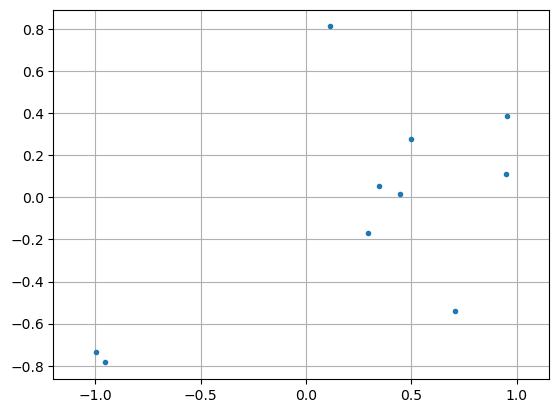

In [2]:
# Plot the points as dots
# The functions first and last simply collects the corresponding indices
using PyPlot
plot(first.(p), last.(p), ".")
axis("equal"); grid(true);

## Convex hull

The *convex hull* of a set $X$ of points is the smallest convex set that contains $X$. In the plane, this is a polygon through a subset of the points. Many algorithms have been proposed for computing the convex hull, and here we will focus on the *Jarvis march* algorithm, also called the *gift wrapping algorithm*.

The method is illustrated below. The main steps are as follows:

1. Find the leftmost point $p_0$ (smallest $x$-coordinate)
2. Find the next point $p_1$ such that all other points are to the right of the line $p_0p_1$
3. Repeat until $p_n=p_0$

![Jarvis_march_convex_hull](jarvis_march_convex_hull.png "Convex Hull")
(from <https://en.wikipedia.org/wiki/Gift_wrapping_algorithm>)

The main utility function needed in the algorithm is to decide if a point $p_2$ is to the right of the line $p_1p_3$. We do this by computing the $z$-coordinate of the cross product of the vectors $p_2-p_1$ and $p_3-p_1$, which is $>0$ if the line $p_1p_2$ is clockwise oriented to the line $p_1p_3$. *Note*: If the lines are parallel this cross product is zero, which is a special case that we for simplicity do not handle here.

In [3]:
function clockwise_oriented(p1, p2, p3)
    # Return true if the line-segment between points p1,p2 is clockwise
    # oriented to the line-segment between points p1,p3
    cross = (p3[2] - p1[2]) * (p2[1] - p1[1]) - (p3[1] - p1[1]) * (p2[2] - p1[2])
    return cross > 0
end

clockwise_oriented (generic function with 1 method)

In [4]:
# Tests
println(clockwise_oriented([0,0], [1,1], [2,3]))
println(clockwise_oriented([0,0], [1,1], [3,2]))

true
false


The method can now be implemented as follows. Note the two loops:

1. The outer loop considers each point $p_0,p_1,\ldots$ on the convex hull. This is a `while` loop, since we do not know beforehand how many points it will include.
2. The inner loop finds the next point such that all other points are to the right of the corresponding line segment. This is done by computing orientations to all other points.

From this, it is clear that the computational complexity of the algorithm is $\mathcal{O}(nh)$, where $n$ is the number of points and $h$ is the number of points on the convex hull.

In [5]:
function convex_hull(p)
    # Find the nodes on the convex hull of the point array p using
    # the Jarvis march (gift wrapping) algorithm

    _, pointOnHull = findmin(first.(p)) # Start at left-most point
    hull = [pointOnHull] # Output: Vector of node indices on the convex hull
    
    while length(hull) ≤ 1 || hull[1] != hull[end] # Loop until closed polygon
        nextPoint = hull[end] % length(p) + 1 # First candidate, any point except current
        for j = 1:length(p) # Consider all other points
            if clockwise_oriented(p[hull[end]], p[nextPoint], p[j]) # If "more to the left", switch
                nextPoint = j
            end
        end
        push!(hull, nextPoint) # Update current point
    end
    return hull
end

convex_hull (generic function with 1 method)

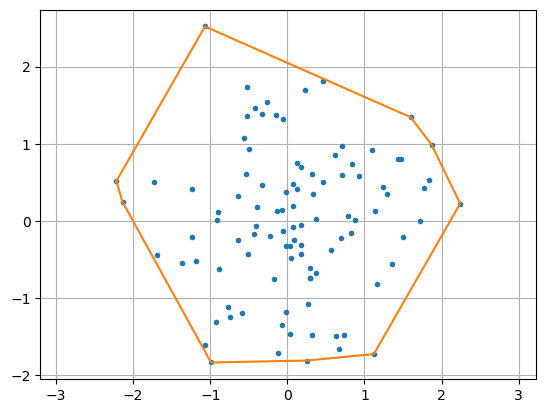

In [6]:
# Example: 100 random points, compute and draw the convex hull
p = [ randn(2) for i = 1:100 ]
hull = convex_hull(p)
plot(first.(p), last.(p), ".")
plot(first.(p[hull]), last.(p[hull]))
axis("equal"); grid(true);